In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlalchemy

from dtaidistance import dtw
from scipy import stats

from database_credentials import get_database_url
from load_transform import load_transform_combine, pivot

In [2]:
def get_number_of_components(graph, get_significant=False):
    """Get the number of components within a graph
    
    Args: 
        graph (networkx graph):
            contains nodes representing trend_ids
            and edges representing dtw distances
            
        get_significant (bool):
            determines whether or not the number of all 
            components or the number of components with 
            more than 3 nodes are returned
    
    Returns:
        num_components (int):
            number of components within the graph
    """
    
    graph_components = nx.connected_components(graph)
    
    if (get_significant):
        components = [
            component for component in graph_components 
            if len(component) > 3
        ]
    else:
        components = [component for component in graph_components]

    num_components = len(components)
    return num_components

In [3]:
plt.style.use('ggplot')
sns.set_style('white')

In [4]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [5]:
sell_data = load_transform_combine(5, connection)
sell_data = pivot(sell_data)
trends = sell_data.to_numpy()

In [6]:
# standardize using z-score
trends = stats.zscore(trends)
num_trends = trends.shape[0]

distances = np.zeros((num_trends, num_trends))
graph = nx.Graph()

# compute distances, build complete graph, save distances
for x, y in np.ndindex(distances.shape):
    if (x > y):
        distance = dtw.distance(trends[x], trends[y])
        graph.add_weighted_edges_from([(x, y, distance)])
        distances[x][y] = distance
        distances[y][x] = distance

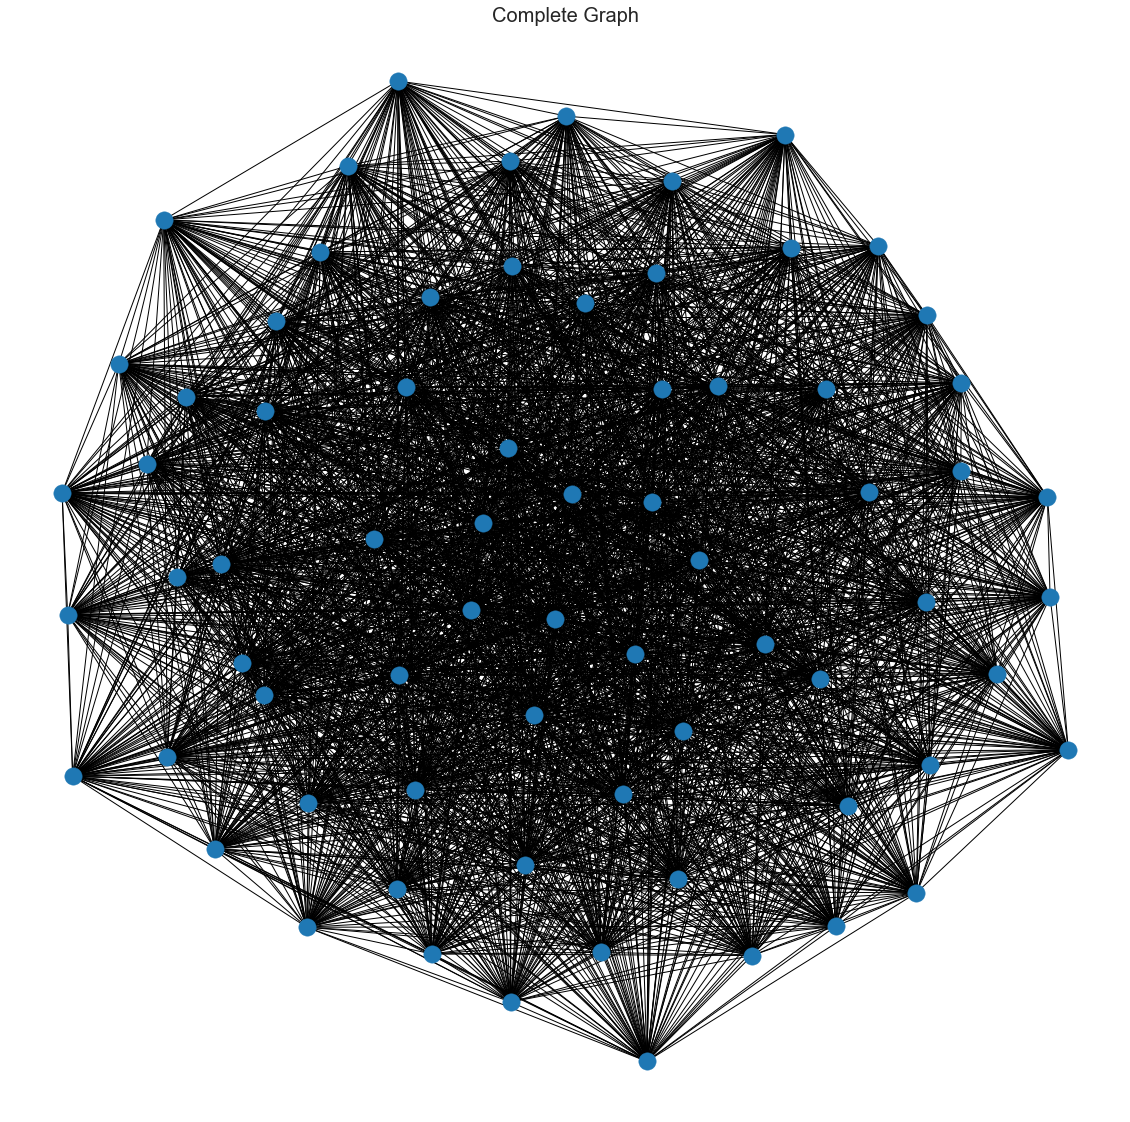

In [7]:
plt.figure(figsize=(20, 20))
plt.title('Complete Graph', fontsize=20)
nx.draw(graph)
plt.show()

In [8]:
min_distance = distances.min()
max_distance = distances.max()

weights = np.linspace(min_distance, max_distance, 1000)
weights = weights[::-1] # reverse to remove edges with larger weights first

graph_copy = graph.copy()

components = []
significant_components = []

for weight in weights:
    edges = graph_copy.edges(data=True)
    edges_beyond_cutoff = [
        edge for edge in edges 
        if edge[2]['weight'] > weight
    ]
    
    graph_copy.remove_edges_from(edges_beyond_cutoff)
    
    num_components = get_number_of_components(graph_copy)
    num_significant_components = (
        get_number_of_components(graph_copy, get_significant=True)
    )
    
    components.append(num_components)
    significant_components.append(num_significant_components)

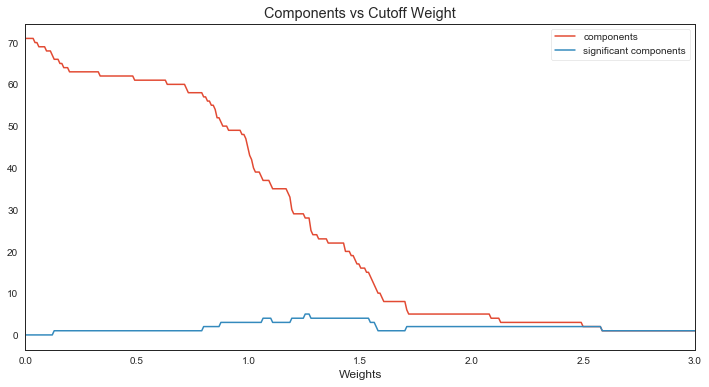

In [16]:
plt.figure(figsize=(12, 6))
plt.title('Components vs Cutoff Weight')
component_plot = sns.lineplot(x=weights, y=components)
significant_component_plot = sns.lineplot(x=weights, y=significant_components)
plt.legend(['components', 'significant components'])
plt.xlabel('Weights')
plt.xlim(0, 3)
plt.ylabel('Number of Compon')
plt.show()

In [10]:
max_significant_components = max(significant_components)
max_index = significant_components.index(max_significant_components)
cutoff_weight = weights[max_index]

In [11]:
remove = [
    edge for edge in graph.edges(data=True) 
    if edge[2]['weight'] > cutoff_weight
]
graph.remove_edges_from(remove)

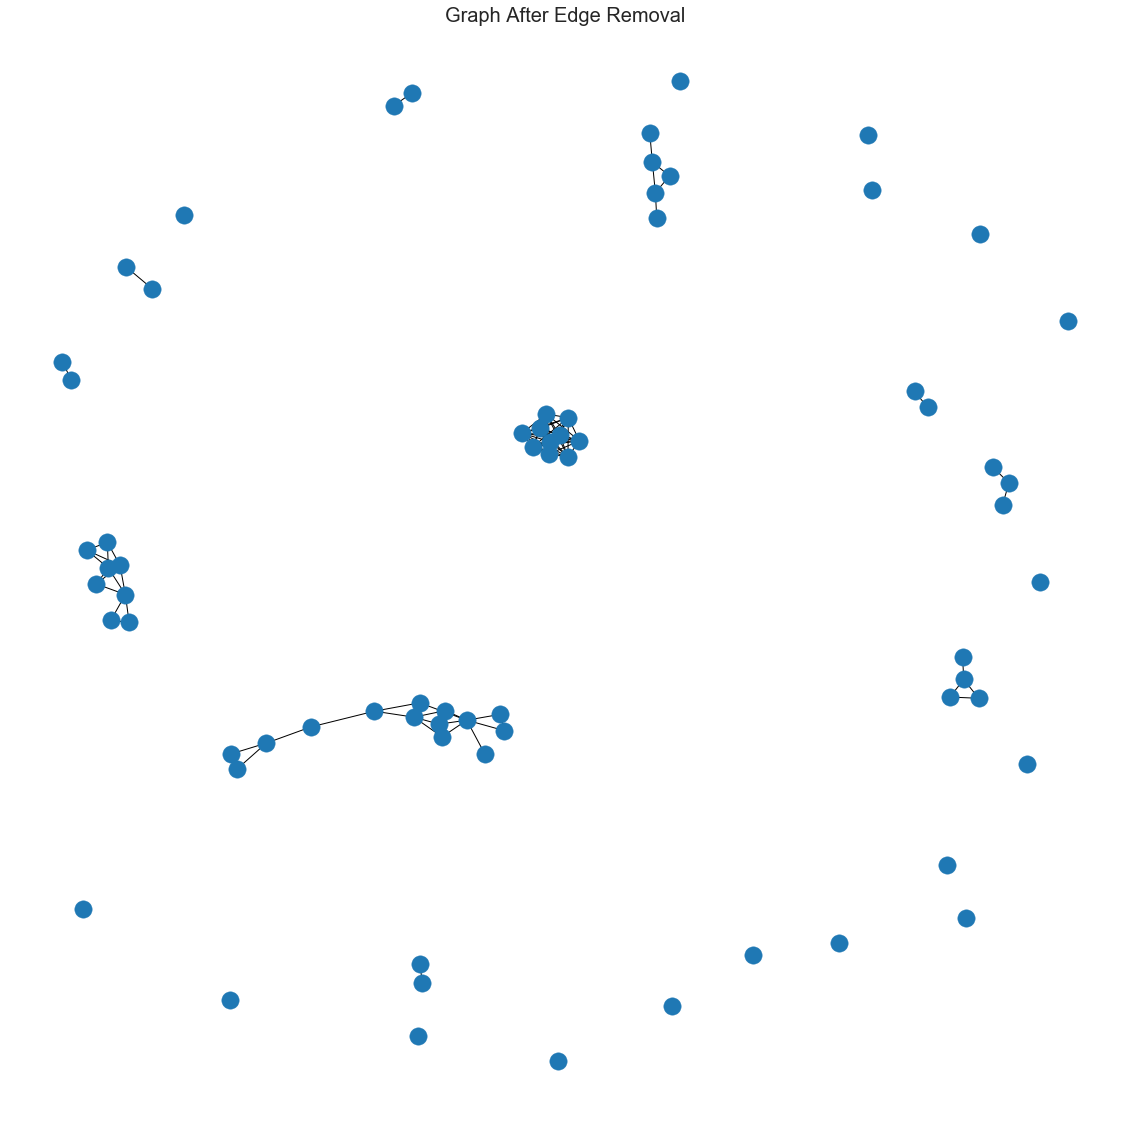

In [15]:
plt.figure(figsize=(20, 20))
plt.title('Graph After Edge Removal', fontsize=20)
nx.draw(graph)
plt.show()

In [13]:
# label components with len == 1 as one group (?)
for component in nx.connected_components(graph):
    print(component)

{64, 1, 38, 11, 50, 21, 62, 30}
{0, 5}
{49, 2}
{3, 6, 46, 57, 31}
{4, 36}
{32, 70, 7, 8, 40, 42, 9, 27, 14, 53, 22, 55, 58, 59}
{10, 23}
{34, 43, 12, 45}
{13}
{15}
{16}
{65, 66, 35, 33, 68, 17, 25, 26, 29, 63}
{18}
{41, 19, 47}
{20}
{24}
{28}
{37}
{39}
{44}
{48}
{51, 61}
{52}
{54}
{56}
{60}
{67}
{69}
